# DEDS Assignment 2

Author: Vincent Itucal

In [13]:
import boto3
import uuid
import random
import pandas as pd
from faker import Faker
from boto3.dynamodb.conditions import Key

## Description of use case and justification for the use of a NoSQL database
Entities Stored in NoSQL
- `LabelObject` - partition key is `label_id` (e.g. `LABEL#1234`) sort key is `METADATA`
- `ArtistObject`- partition key is `artist_id` (e.g. `ARTIST#1234`) sort key is `METADATA`
- `SongObject` - with columns: 
  - `song_id` - (e.g. `SONG#1234`)
  - `label_id`
  - `artist_id`
  - `song_title`
  - `label_name`
  - `artist_name`
  - `play_count`
  - `sold_amount_in_php`

Access patterns:
- Get all songs under a label
- Get all songs by artist
- Get songs by artist or label on `play_count` condition
- Get songs by artist or label on `sold_amount_in_php` condition

## Python code for adding the items

In [65]:
fake = Faker()
s3_client = boto3.client("s3")
dynamodb = boto3.resource('dynamodb', region_name='us-east-1')
table_name = "nosql_music_stream_service"
table = dynamodb.Table(table_name)

In [66]:
# Generate Labels
labels = []
for i in range(3):
    label_id = f"LABEL#{i+1}"
    labels.append({"pk": label_id, "sk": "METADATA", "label_name": fake.company()})

# Generate Artists
artists = []
for i in range(17):
    label = random.choice(labels)
    artist_id = f"ARTIST#{i+1}"
    artists.append({"pk": artist_id, "sk": "METADATA", "artist_name": fake.name(), "label_id": label["pk"]})

# Generate Songs
songs = []
for i in range(80):
    artist = random.choice(artists)
    label = next(l for l in labels if l["pk"] == artist["label_id"])
    song_id = f"SONG#{i+1}"
    song = {
        "pk": song_id,
        "sk": "METADATA",
        "song_title": fake.sentence(nb_words=3),
        "artist_id": artist["pk"],
        "artist_name": artist["artist_name"],
        "label_id": label["pk"],
        "label_name": label["label_name"],
        "play_count": random.randint(1000, 100000),
        "sold_amount_in_php": random.randint(50000, 1000000)
    }
    songs.append(song)

In [67]:
for label in labels:
    table.put_item(Item=label)
for artist in artists:
    table.put_item(Item=artist)
for song in songs:
    table.put_item(Item=song)

##  Screenshot of dynamodb table items. The table should have at least 100 items.

In [68]:
scan_response = table.scan()
print(f"Item count: {scan_response['Count']}")
all_scan = pd.DataFrame(scan_response['Items'])
display(all_scan)

Item count: 100


,artist_id,label_name,play_count,sold_amount_in_php,sk,artist_name,label_id,pk,song_title
0,ARTIST#3,Aguirre Ltd,30530,656367,METADATA,Mackenzie Gonzalez,LABEL#3,SONG#14,Short whatever tonight.
1,NaN,NaN,NaN,NaN,METADATA,Brandon Vasquez,LABEL#3,ARTIST#4,NaN
2,ARTIST#9,Aguirre Ltd,62308,374814,METADATA,Scott Garrett,LABEL#3,SONG#9,Certain.
3,ARTIST#11,"Lopez, Torres and Norris",20960,259246,METADATA,Cody Gray,LABEL#1,SONG#63,Central southern.
4,ARTIST#2,Aguirre Ltd,8282,763056,METADATA,Allison Green,LABEL#3,SONG#2,Program behind water.
...,...,...,...,...,...,...,...,...,...
95,ARTIST#15,"Nixon, Williams and Solis",90450,763397,METADATA,Kathleen Duran,LABEL#2,SONG#79,Young stage.
96,ARTIST#7,"Lopez, Torres and Norris",17410,234439,METADATA,Timothy George,LABEL#1,SONG#72,Leader just start.
97,ARTIST#8,Aguirre Ltd,5156,85405,METADATA,Alexis Martin,LABEL#3,SONG#45,Parent morning know.
98,ARTIST#17,"Lopez, Torres and Norris",60551,104202,METADATA,Michelle Nelson,LABEL#1,SONG#29,Would point old.


Put this to raw zone

In [53]:
csv_buffer = all_scan.to_csv(index=False)
s3_client.put_object(
    Bucket="datalake-music-streaming",
    Key="landing/all_scan.csv",
    Body=csv_buffer
)

{'ResponseMetadata': {'RequestId': 'A252BBBE8M6R52R6',
  'HostId': 'iAAkhmfVihjPQWqIGr34n55LiM2BRlHobPro+ZS6QOSP3CNbu4bXB0NvHu4tVKxMXYGOncWGhno=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'iAAkhmfVihjPQWqIGr34n55LiM2BRlHobPro+ZS6QOSP3CNbu4bXB0NvHu4tVKxMXYGOncWGhno=',
   'x-amz-request-id': 'A252BBBE8M6R52R6',
   'date': 'Sun, 02 Mar 2025 14:43:01 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"88c7396ca0d29c0b938657b2844f1e35"',
   'x-amz-checksum-crc32': 'iCBFWw==',
   'x-amz-checksum-type': 'FULL_OBJECT',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"88c7396ca0d29c0b938657b2844f1e35"',
 'ChecksumCRC32': 'iCBFWw==',
 'ChecksumType': 'FULL_OBJECT',
 'ServerSideEncryption': 'AES256'}

## Curated Queries
- Get songs by `artist_id` with less than or equal 100k `play_count`
- Get songs by `artist_id` with greater than or equal 100k `sold_amount_in_php`
- Get songs by `label_id` with less than or equal 100k `play_count`
- Get songs by `label_id` with greater than or equal 100k `sold_amount_in_php`

In [86]:
resp = table.query(
    IndexName="artist_id-play_count-index",
    KeyConditionExpression=(
        Key("artist_id").eq("ARTIST#17") & Key("play_count").lte(100_000)
    ),
    ScanIndexForward=False,  # Sort by play_count DESC
)
curated_1 = pd.DataFrame(resp['Items'])

In [87]:
resp = table.query(
    IndexName="artist_id-sold_amount_in_php-index",
    KeyConditionExpression=(
        Key("artist_id").eq("ARTIST#17") & Key("sold_amount_in_php").gte(100_000)
    ),
    ScanIndexForward=False,  # Sort by play_count DESC
)
curated_2 = pd.DataFrame(resp['Items'])

In [88]:
resp = table.query(
    IndexName="label_id-play_count-index",
    KeyConditionExpression=(
        Key("label_id").eq("LABEL#1") & Key("play_count").lte(100_000)
    ),
    ScanIndexForward=False,  # Sort by play_count DESC
)
curated_3 = pd.DataFrame(resp['Items'])

In [89]:
resp = table.query(
    IndexName="label_id-sold_amount_in_php-index",
    KeyConditionExpression=(
        Key("label_id").eq("LABEL#1") & Key("sold_amount_in_php").gte(100_000)
    ),
    ScanIndexForward=False,  # Sort by play_count DESC
)
curated_4 = pd.DataFrame(resp['Items'])

In [90]:
display(curated_1)
display(curated_2)
display(curated_3)
display(curated_4)

,artist_id,label_name,sold_amount_in_php,sk,play_count,artist_name,label_id,pk,song_title
0,ARTIST#17,"Lopez, Torres and Norris",254409,METADATA,92677,Michelle Nelson,LABEL#1,SONG#49,Have character page decision.
1,ARTIST#17,"Lopez, Torres and Norris",104202,METADATA,60551,Michelle Nelson,LABEL#1,SONG#29,Would point old.
2,ARTIST#17,"Lopez, Torres and Norris",493925,METADATA,49969,Michelle Nelson,LABEL#1,SONG#76,Service approach produce.
3,ARTIST#17,"Lopez, Torres and Norris",321314,METADATA,44699,Michelle Nelson,LABEL#1,SONG#36,Art day tend.
4,ARTIST#17,"Lopez, Torres and Norris",680037,METADATA,20836,Michelle Nelson,LABEL#1,SONG#20,Fill base.
5,ARTIST#17,"Lopez, Torres and Norris",163584,METADATA,7355,Michelle Nelson,LABEL#1,SONG#4,Wrong bit.


,artist_id,label_name,play_count,sk,sold_amount_in_php,artist_name,label_id,pk,song_title
0,ARTIST#17,"Lopez, Torres and Norris",20836,METADATA,680037,Michelle Nelson,LABEL#1,SONG#20,Fill base.
1,ARTIST#17,"Lopez, Torres and Norris",49969,METADATA,493925,Michelle Nelson,LABEL#1,SONG#76,Service approach produce.
2,ARTIST#17,"Lopez, Torres and Norris",44699,METADATA,321314,Michelle Nelson,LABEL#1,SONG#36,Art day tend.
3,ARTIST#17,"Lopez, Torres and Norris",92677,METADATA,254409,Michelle Nelson,LABEL#1,SONG#49,Have character page decision.
4,ARTIST#17,"Lopez, Torres and Norris",7355,METADATA,163584,Michelle Nelson,LABEL#1,SONG#4,Wrong bit.
5,ARTIST#17,"Lopez, Torres and Norris",60551,METADATA,104202,Michelle Nelson,LABEL#1,SONG#29,Would point old.


,artist_id,label_name,sold_amount_in_php,sk,play_count,artist_name,label_id,pk,song_title
0,ARTIST#17,"Lopez, Torres and Norris",254409,METADATA,92677,Michelle Nelson,LABEL#1,SONG#49,Have character page decision.
1,ARTIST#16,"Lopez, Torres and Norris",131017,METADATA,87936,Ashley Cole,LABEL#1,SONG#73,Commercial paper large.
2,ARTIST#1,"Lopez, Torres and Norris",761125,METADATA,85456,Cassie Padilla,LABEL#1,SONG#56,Way black find.
3,ARTIST#10,"Lopez, Torres and Norris",772420,METADATA,79115,Jessica Cobb,LABEL#1,SONG#47,Level sister movie.
4,ARTIST#1,"Lopez, Torres and Norris",982458,METADATA,78525,Cassie Padilla,LABEL#1,SONG#35,Food lay political.
5,ARTIST#7,"Lopez, Torres and Norris",222050,METADATA,77634,Timothy George,LABEL#1,SONG#26,Sea who senior.
6,ARTIST#11,"Lopez, Torres and Norris",565545,METADATA,76294,Cody Gray,LABEL#1,SONG#71,Enjoy less summer.
7,ARTIST#7,"Lopez, Torres and Norris",945172,METADATA,69255,Timothy George,LABEL#1,SONG#44,Effect eye keep.
8,ARTIST#10,"Lopez, Torres and Norris",722809,METADATA,67176,Jessica Cobb,LABEL#1,SONG#70,Total toward.
9,ARTIST#16,"Lopez, Torres and Norris",464566,METADATA,64756,Ashley Cole,LABEL#1,SONG#67,According board feel natural.


,artist_id,label_name,play_count,sk,sold_amount_in_php,artist_name,label_id,pk,song_title
0,ARTIST#1,"Lopez, Torres and Norris",78525,METADATA,982458,Cassie Padilla,LABEL#1,SONG#35,Food lay political.
1,ARTIST#11,"Lopez, Torres and Norris",30111,METADATA,969696,Cody Gray,LABEL#1,SONG#1,Trip hotel.
2,ARTIST#7,"Lopez, Torres and Norris",69255,METADATA,945172,Timothy George,LABEL#1,SONG#44,Effect eye keep.
3,ARTIST#10,"Lopez, Torres and Norris",33265,METADATA,918065,Jessica Cobb,LABEL#1,SONG#74,Star information.
4,ARTIST#10,"Lopez, Torres and Norris",59060,METADATA,894098,Jessica Cobb,LABEL#1,SONG#15,Week.
5,ARTIST#7,"Lopez, Torres and Norris",13249,METADATA,808115,Timothy George,LABEL#1,SONG#39,Share shoulder.
6,ARTIST#10,"Lopez, Torres and Norris",79115,METADATA,772420,Jessica Cobb,LABEL#1,SONG#47,Level sister movie.
7,ARTIST#1,"Lopez, Torres and Norris",85456,METADATA,761125,Cassie Padilla,LABEL#1,SONG#56,Way black find.
8,ARTIST#10,"Lopez, Torres and Norris",67176,METADATA,722809,Jessica Cobb,LABEL#1,SONG#70,Total toward.
9,ARTIST#17,"Lopez, Torres and Norris",20836,METADATA,680037,Michelle Nelson,LABEL#1,SONG#20,Fill base.


## Save curate queries to `gold`

In [91]:
def save_to_s3(df, dataset_name):
    path = f"s3://datalake-music-streaming/gold/{dataset_name}/"
    df.to_parquet(path, index=False)
    print(f"Saved {dataset_name} to {path}")

# Assuming curated_1 to curated_4 exist
save_to_s3(curated_1, "curated_1")
save_to_s3(curated_2, "curated_2")
save_to_s3(curated_3, "curated_3")
save_to_s3(curated_4, "curated_4")

Saved curated_1 to s3://datalake-music-streaming/gold/curated_1/
Saved curated_2 to s3://datalake-music-streaming/gold/curated_2/
Saved curated_3 to s3://datalake-music-streaming/gold/curated_3/
Saved curated_4 to s3://datalake-music-streaming/gold/curated_4/


## Simple Data Lake Setup
Just 2 roles and 3 zones for simplicity in this assignment.

Roles:
- `Data Engineer`
- `Data Scientist`

Directory Structure and Zones:
- `datalake-music-streaming` bucket
  - `landing`
    - Landing zone for data dump from DynamoDB.
    - Accessible by: `Data Engineer`
  - `work`
    - Contains notebooks etc.
    - Accessible by: `Data Scientist`, `Data Engineer`
  - `gold`
    - Curated data for business use.
    - Accessible by: `Data Scientist`

### Bucket screenshot

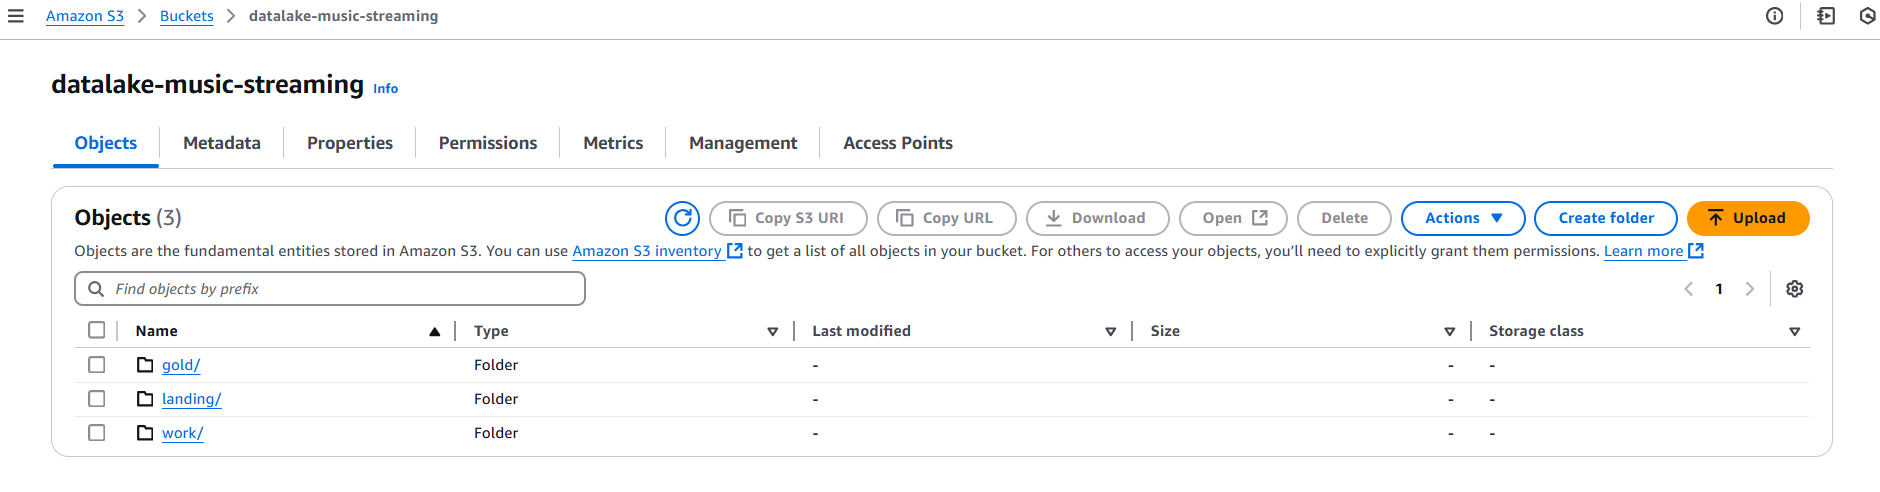

## Contents

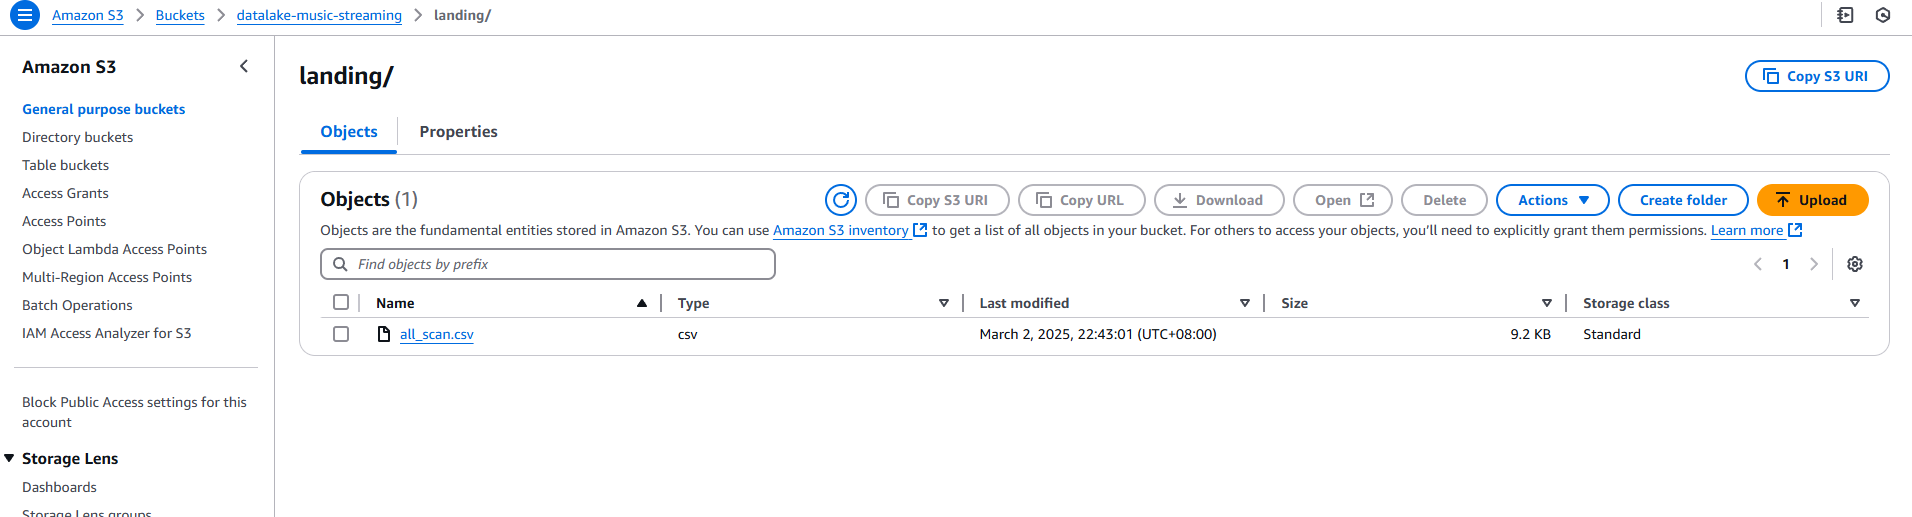
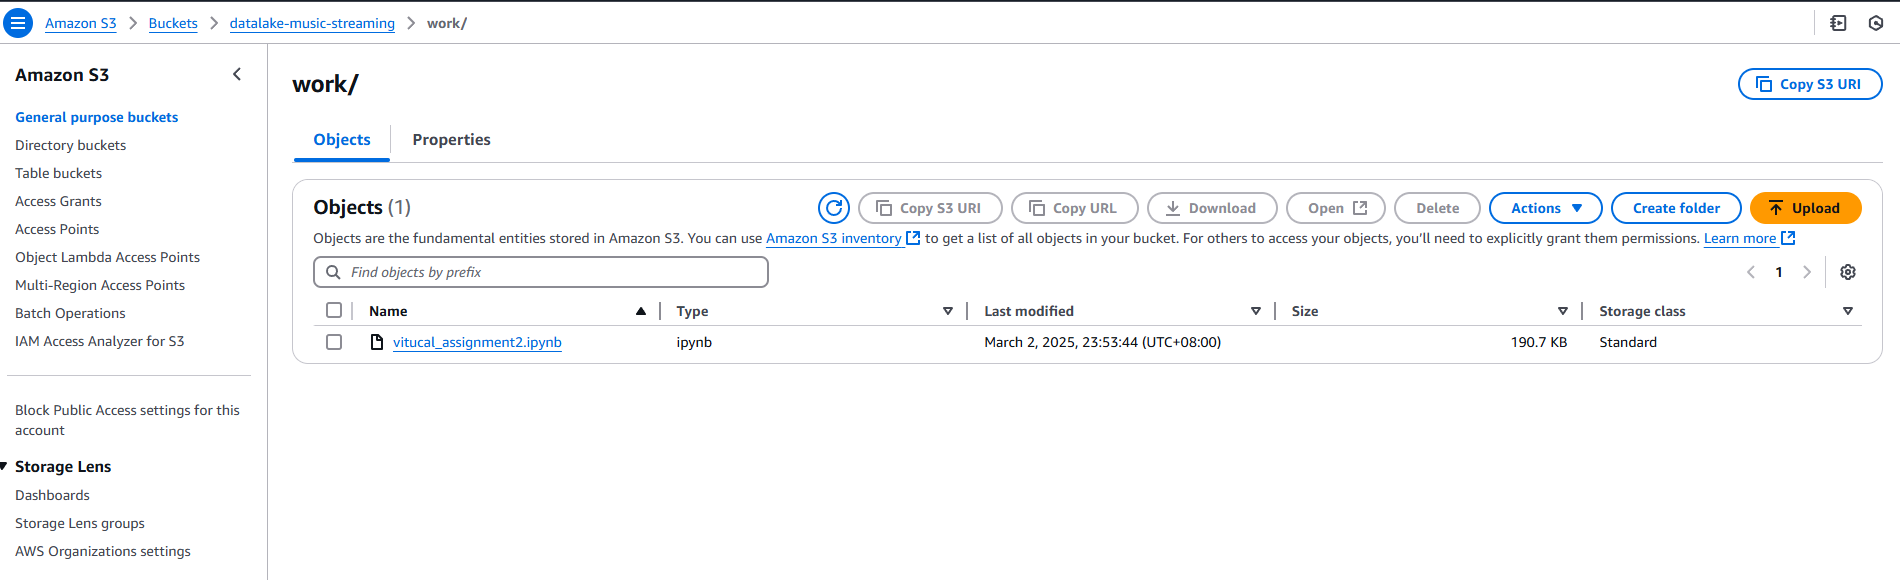
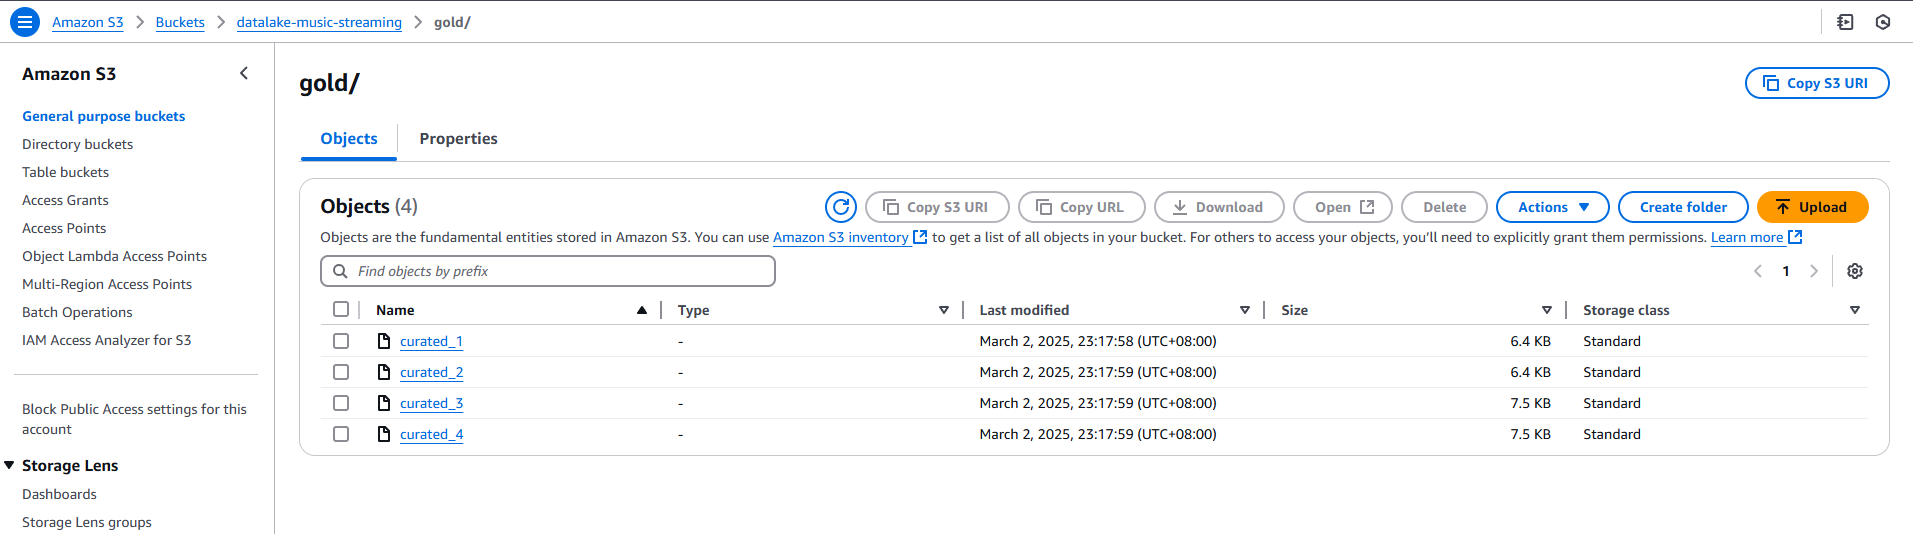

## Access summary with aws profiles

Data Engineer IAM role for S3
```
{
	"Version": "2012-10-17",
	"Statement": [
		{
			"Effect": "Allow",
			"Action": [
				"s3:ListBucket"
			],
			"Resource": "arn:aws:s3:::datalake-music-streaming",
			"Condition": {
				"StringLike": {
					"s3:prefix": [
						"landing/*",
						"work/*",
						"landing",
						"work"
					]
				}
			}
		},
		{
			"Effect": "Allow",
			"Action": [
				"s3:GetObject",
				"s3:PutObject",
				"s3:DeleteObject"
			],
			"Resource": [
				"arn:aws:s3:::datalake-music-streaming/landing/*",
				"arn:aws:s3:::datalake-music-streaming/work/*"
			]
		},
		{
			"Effect": "Deny",
			"Action": "s3:ListBucket",
			"Resource": "arn:aws:s3:::datalake-music-streaming",
			"Condition": {
				"StringLike": {
					"s3:prefix": "gold/*"
				}
			}
		},
		{
			"Effect": "Deny",
			"Action": [
				"s3:GetObject",
				"s3:PutObject",
				"s3:DeleteObject"
			],
			"Resource": "arn:aws:s3:::datalake-music-streaming/gold/*"
		}
	]
}
```
Data Scientist IAM role for S3
```
{
	"Version": "2012-10-17",
	"Statement": [
		{
			"Effect": "Allow",
			"Action": [
				"s3:ListBucket"
			],
			"Resource": "arn:aws:s3:::datalake-music-streaming",
			"Condition": {
				"StringLike": {
					"s3:prefix": [
						"work/*",
						"gold/*",
						"work",
						"gold"
					]
				}
			}
		},
		{
			"Effect": "Allow",
			"Action": [
				"s3:GetObject",
				"s3:PutObject",
				"s3:DeleteObject"
			],
			"Resource": [
				"arn:aws:s3:::datalake-music-streaming/work/*"
			]
		},
		{
			"Effect": "Allow",
			"Action": "s3:GetObject",
			"Resource": "arn:aws:s3:::datalake-music-streaming/gold/*"
		},
		{
			"Effect": "Deny",
			"Action": "s3:ListBucket",
			"Resource": "arn:aws:s3:::datalake-music-streaming",
			"Condition": {
				"StringLike": {
					"s3:prefix": "landing/*"
				}
			}
		},
		{
			"Effect": "Deny",
			"Action": [
				"s3:PutObject",
				"s3:DeleteObject"
			],
			"Resource": "arn:aws:s3:::datalake-music-streaming/gold/*"
		}
	]
}
```

In [95]:
bucket_name = "datalake-music-streaming"
directories = ["landing/", "work/", "gold"]

In [96]:
de_session = boto3.Session(profile_name="data_engineer")
s3_client_de = de_session.client("s3")

for directory in directories:
    try:
        response = s3_client_de.list_objects_v2(Bucket=bucket_name, Prefix=directory, MaxKeys=5)
        if "Contents" in response:
            print(f"Access granted to {bucket_name}/{directory} contents:")
            for obj in response['Contents']:
                print(f"- {obj['Key']}")
    except s3_client_de.exceptions.ClientError as e:
        print(f"- Access denied for {bucket_name}/{directory}: \n{e.response['Error']['Message']}")

Access granted to datalake-music-streaming/landing/ contents:
- landing/
- landing/all_scan.csv
Access granted to datalake-music-streaming/work/ contents:
- work/
- work/vitucal_assignment2.ipynb
- Access denied for datalake-music-streaming/gold: 
User: arn:aws:iam::277707127732:user/v_de is not authorized to perform: s3:ListBucket on resource: "arn:aws:s3:::datalake-music-streaming" because no identity-based policy allows the s3:ListBucket action


In [97]:
ds_session = boto3.Session(profile_name="data_scientist")
s3_client_ds = ds_session.client("s3")

for directory in directories:
    try:
        response = s3_client_ds.list_objects_v2(Bucket=bucket_name, Prefix=directory, MaxKeys=5)
        if "Contents" in response:
            print(f"Access granted to {bucket_name}/{directory} contents:")
            for obj in response['Contents']:
                print(f"- {obj['Key']}")
    except s3_client_ds.exceptions.ClientError as e:
        print(f"- Access denied for {bucket_name}/{directory}: \n{e.response['Error']['Message']}")

- Access denied for datalake-music-streaming/landing/: 
User: arn:aws:iam::277707127732:user/v_ds is not authorized to perform: s3:ListBucket on resource: "arn:aws:s3:::datalake-music-streaming" with an explicit deny in an identity-based policy
Access granted to datalake-music-streaming/work/ contents:
- work/
- work/vitucal_assignment2.ipynb
Access granted to datalake-music-streaming/gold contents:
- gold/
- gold/curated_1
- gold/curated_2
- gold/curated_3
- gold/curated_4
